# Ciuicci et al 2019 data analysis
## Philipp Burt

# packages

In [3]:
import scanpy as sc #for scanpy >= 1.3.7
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

filepath = "C:/Users/Philipp/OneDrive/projects/2020/tcell_scRNAseq/data/ciucci_2019/"
data_path = "GSE121002_RAW/GSM3423796/"
filepath = filepath+data_path

adata = sc.read_10x_mtx(filepath, cache = True)
print(adata)

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.0
... writing an h5ad cache file to speedup reading next time
AnnData object with n_obs × n_vars = 737280 × 27998
    var: 'gene_ids'


# Quality control (gene counts, cell counts, mitochondria content)

Total number of cells: 737280
filtered out 657559 cells that have less than 5 counts
filtered out 77214 cells that have less than 200 genes expressed
filtered out 14755 genes that are detected in less than 2 cells
Total number of cells after prefiltering: 2507


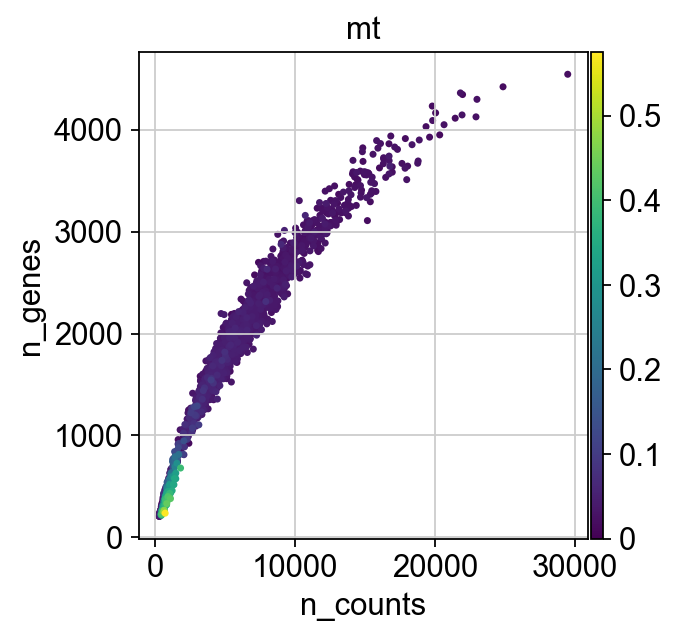

Total number of cells: 2507


In [4]:
# basic prefiltering to reduce matrix
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_counts = 5)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=2)

# Filter cells according to identified QC thresholds:
print('Total number of cells after prefiltering: {:d}'.format(adata.n_obs))

# add mitochondrial gene fraction, code taken from 10x tutorial scanpy. note that mouse mito genes start as mt-
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['n_genes'] = (adata.X > 0).sum(1)
mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']
#Data quality summary plots with mitochondrial gene content as color code
p1 = sc.pl.scatter(adata, x = 'n_counts', y ='n_genes', color = "mt", size=40)

print('Total number of cells: {:d}'.format(adata.n_obs))


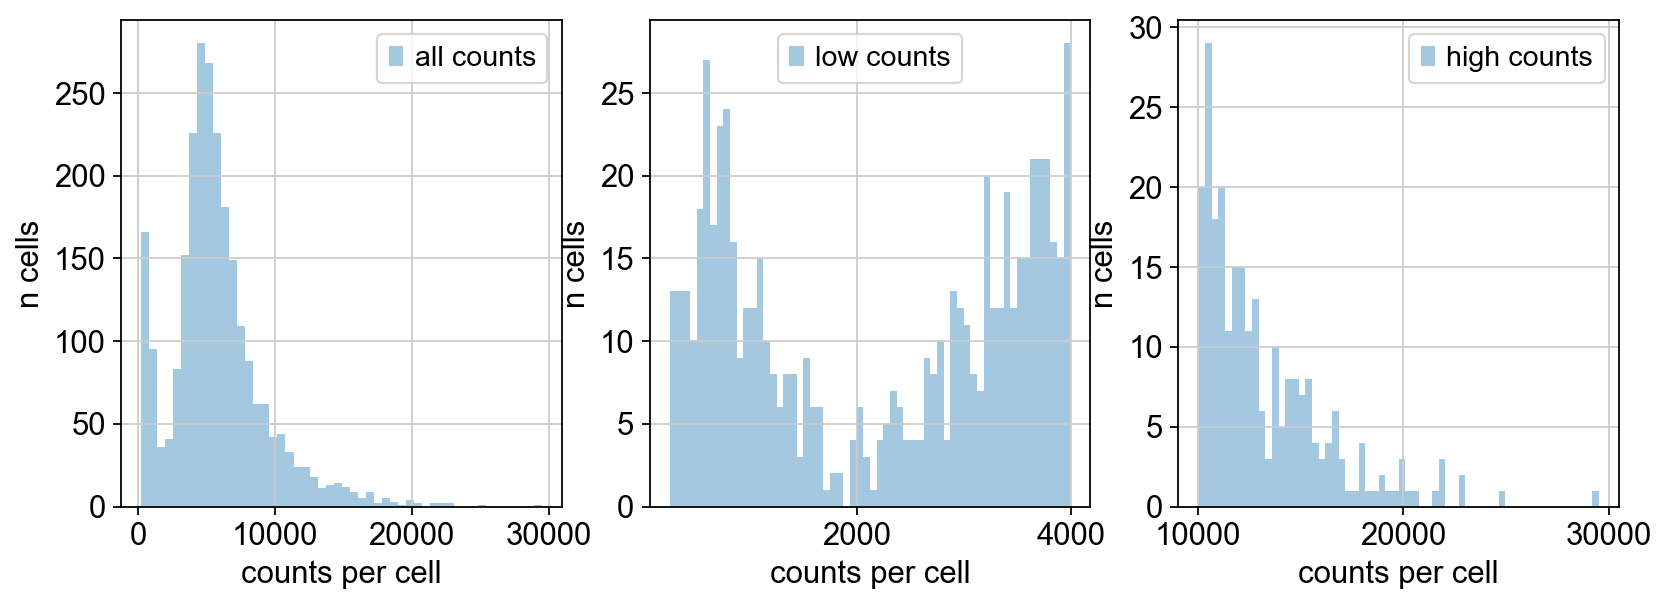

Total number of cells: 2507


In [5]:
#filter based on total counts
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

p1 = sns.distplot(adata.obs['n_counts'], 
                 kde=False, 
                 ax=ax1, label = "all counts")
p2 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], 
                 kde=False, bins=60, 
                 ax=ax2, label = "low counts")
p3 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], 
                 kde=False, bins=60, 
                 ax=ax3, label = "high counts")
for ax in [ax1, ax2, ax3]:
    ax.legend()
    ax.set_ylabel("n cells")
    ax.set_xlabel("counts per cell")
plt.show()

print('Total number of cells: {:d}'.format(adata.n_obs))

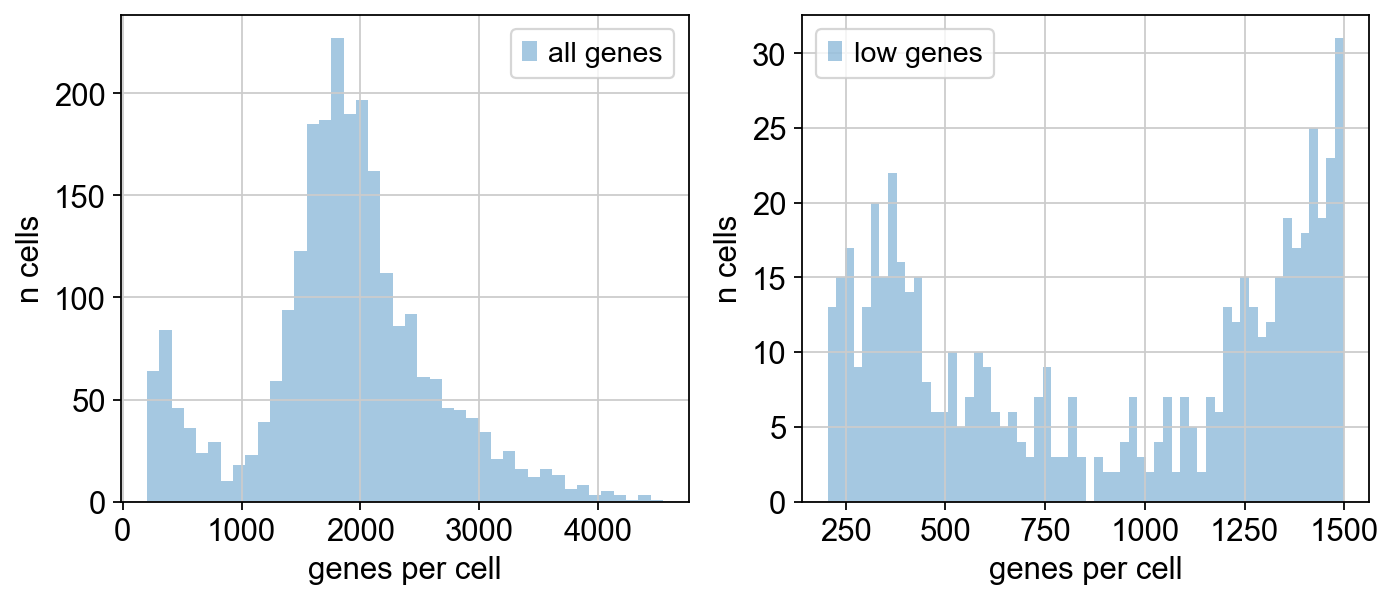

Total number of cells: 2507


In [6]:
#filter based on total counts
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

p1 = sns.distplot(adata.obs['n_genes'], 
                 kde=False, 
                 ax=ax1, label = "all genes")
p2 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1500], 
                 kde=False, bins=60, 
                 ax=ax2, label = "low genes")

for ax in [ax1, ax2]:
    ax.legend()
    ax.set_ylabel("n cells")
    ax.set_xlabel("genes per cell")
plt.show()

print('Total number of cells: {:d}'.format(adata.n_obs))

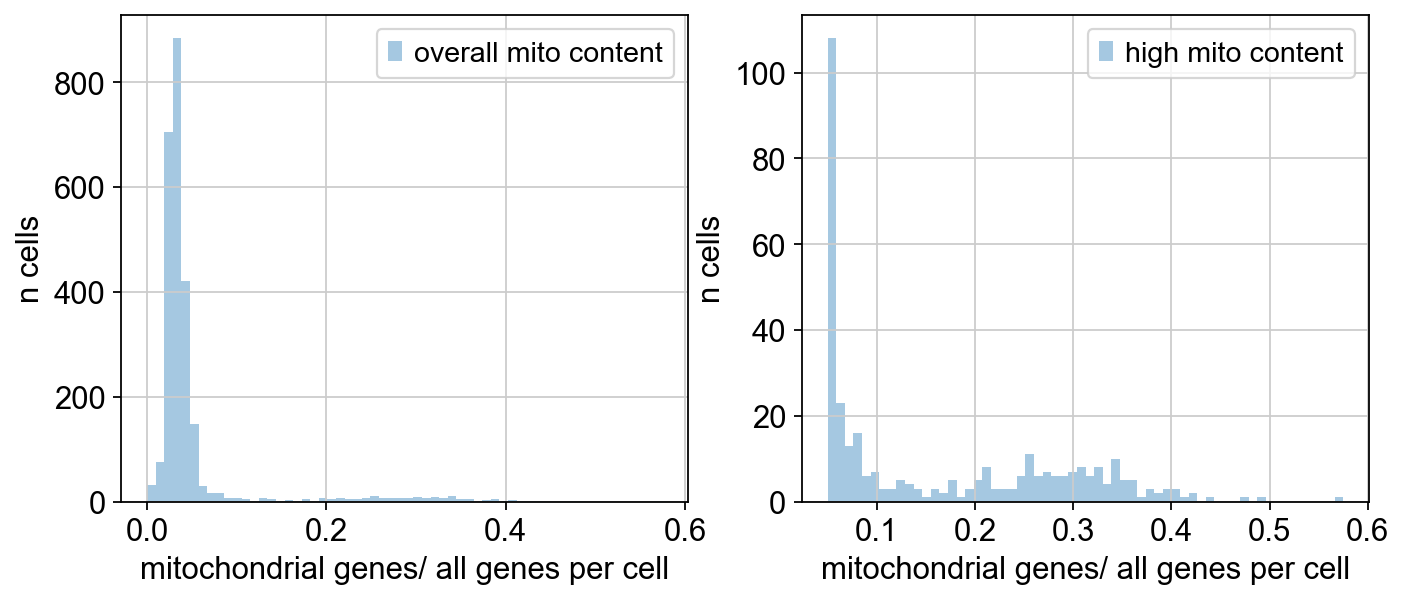

Total number of cells: 2507


In [7]:
# mitochondrial genes
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))
p1 = sns.distplot(adata.obs['mt'], kde=False, bins=60, ax=ax1, label = "overall mito content")

p2 = sns.distplot(adata.obs['mt'][adata.obs['mt']>0.05], 
                 kde=False, bins=60, ax=ax2, label = "high mito content")

for ax in [ax1, ax2]:
    ax.legend()
    ax.set_ylabel("n cells")
    ax.set_xlabel("mitochondrial genes/ all genes per cell")
plt.show()

plt.show()

print('Total number of cells: {:d}'.format(adata.n_obs))

# filtering based on quality control
looking at above histograms following filter criteria are applied
- filter cells w less than 2000 counts
- filter cells w more than 20000 counts
- filter cells w less than 500 genes (taken from paper, seems low but within reasonable range)
- filter cells w mito content higher than 0.1 (taken from paper)

In [8]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 2000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 20000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt'] < 0.1]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 500)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

print("note that in original paper they have 2213 cells after preprocessing")

Total number of cells: 2507
filtered out 295 cells that have less than 2000 counts
Number of cells after min count filter: 2212
filtered out 11 cells that have more than 20000 counts
Number of cells after max count filter: 2201
Number of cells after MT filter: 2195


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 2195
note that in original paper they have 2213 cells after preprocessing


In [10]:
savepath = "C:/Users/Philipp/OneDrive/projects/2020/tcell_scRNAseq/output/cleaned_datasets/"
adata.write(savepath+"anndata_filtered_ciucci_2019.h5ad")

# Normalization
- library size correct
- log transform
- highly variable genes calculation (downstream analysis like PCA only done on them)

In [11]:
# normalize library size for each cell by dividing over total counts per cell and multiply by 1e6
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata) # log
#Set the .raw attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations 
#of gene expression. This simply freezes the state of the AnnData object.
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


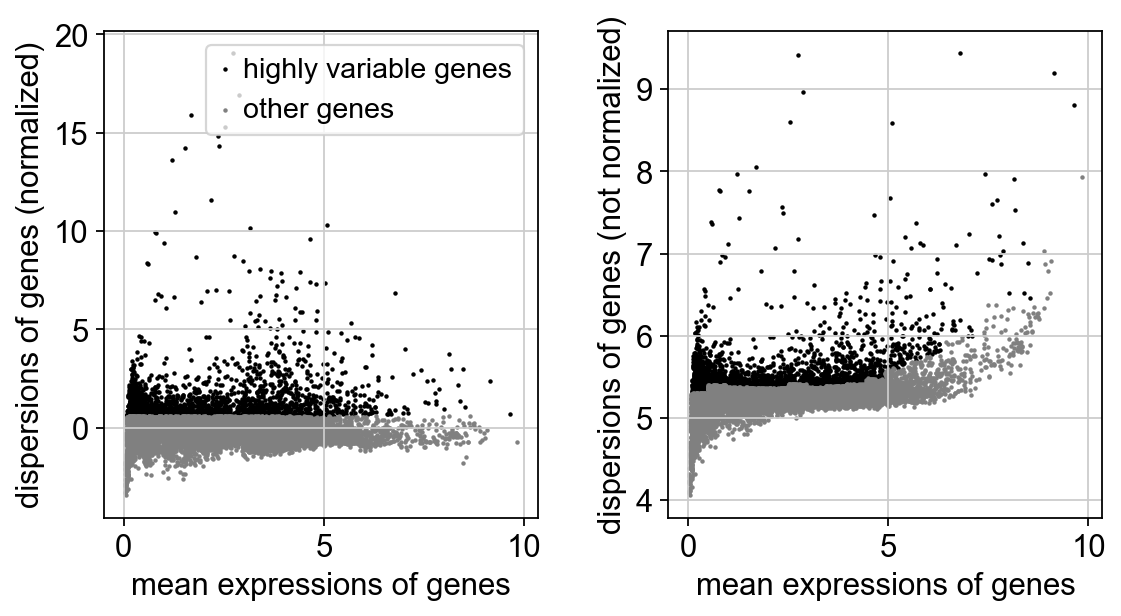

In [12]:
# in original study they use highly variable genes for PCA and clustering but then if I scale it does not
# identify highly variable genes, this is used for PCA later
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
sc.pl.highly_variable_genes(adata)

#sc.pp.scale(adata, max_value=10)

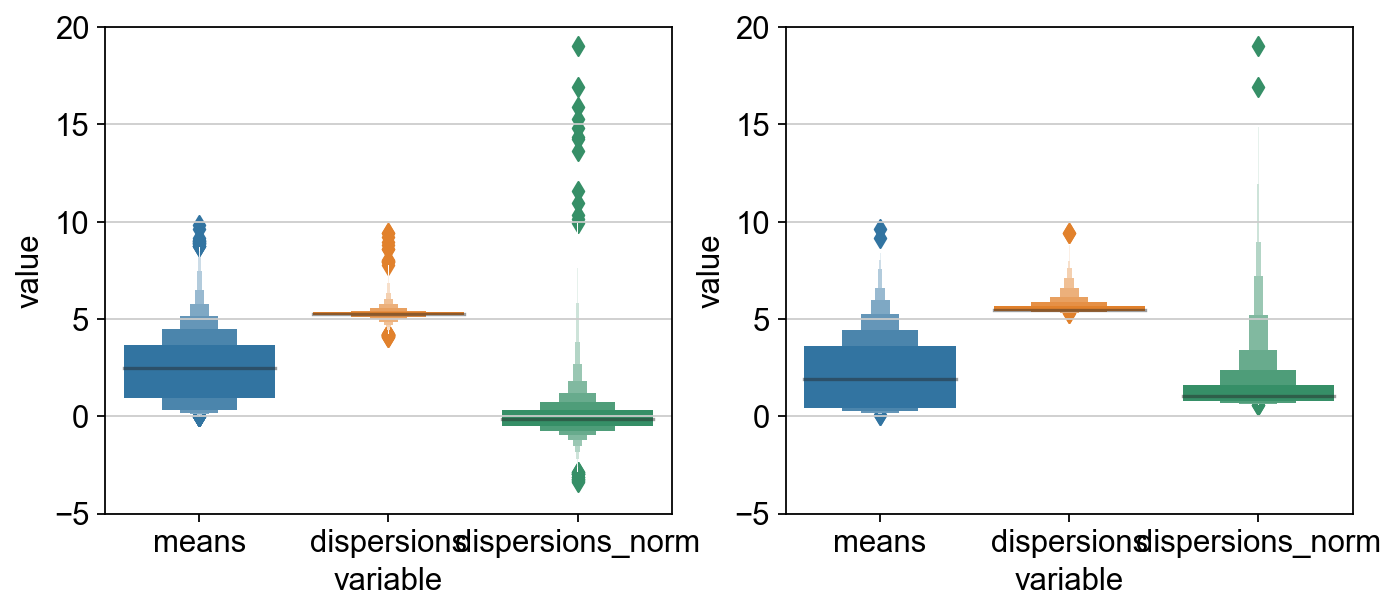

In [13]:
df = adata.var[["highly_variable", "means", "dispersions", "dispersions_norm"]]
df.to_csv("../output/variance_ciucci_2019.csv")

df2 = df.melt(id_vars = ["highly_variable"])
df_var = df2[df2.highly_variable == True]


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))
sns.boxenplot(data = df2, x = "variable", y = "value", ax = ax1)
sns.boxenplot(data = df_var, x = "variable", y = "value", ax = ax2)

ylim = (-5,20)
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)

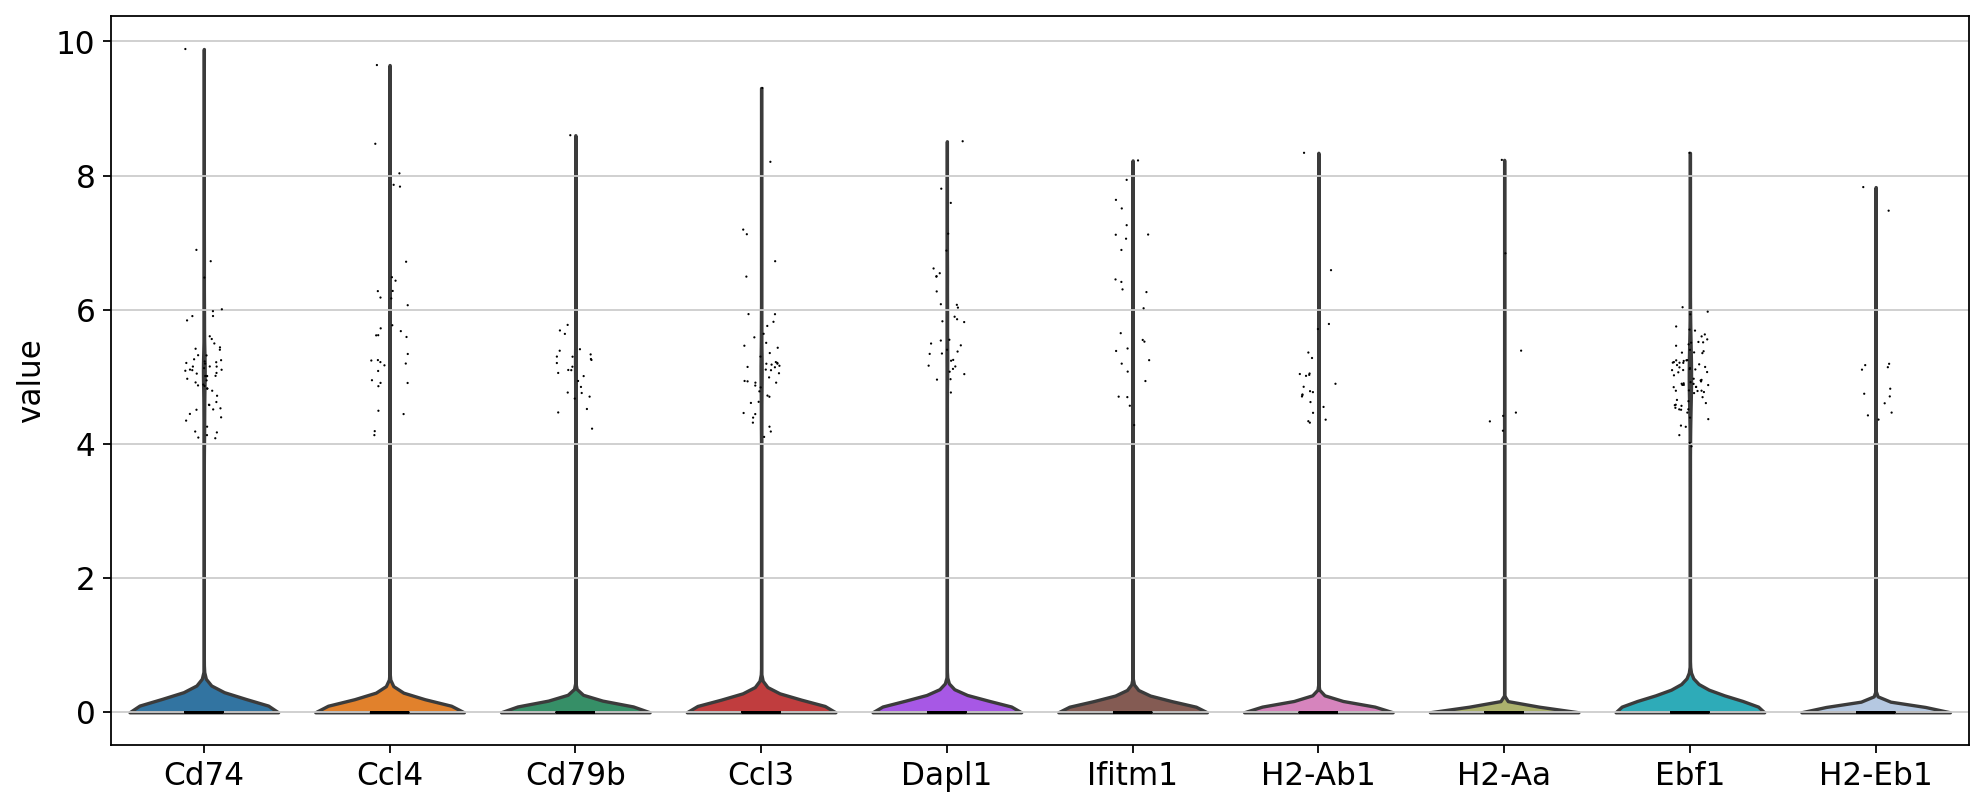

In [10]:
# find the top variable genes
#df.sort_values(by = "dispersions_norm", ascending = False)
#top_var_genes = df.index.values
#top_var_genes = top_var_genes[:10]
df_sorted = df.sort_values(by = "dispersions_norm", ascending = False)
genes_sorted = df_sorted.index.values
top_var_genes = genes_sorted[:10]

rcParams['figure.figsize']=(12,6)
sc.pl.violin(adata, top_var_genes)

In [27]:
# only proceed with downstream analysis for highly variable genes
adata = adata[:, adata.var.highly_variable]

,gene_ids,n_cells,highly_variable,means,dispersions,dispersions_norm
Gm37988,ENSMUSG00000104217,4,True,0.237348,5.310592,0.620135
Pcmtd1,ENSMUSG00000051285,503,True,3.873933,5.416876,0.772399
Gm26901,ENSMUSG00000097797,3,True,0.217610,5.357495,0.771794
Cspp1,ENSMUSG00000056763,552,True,3.935685,5.432956,0.708335
Rdh10,ENSMUSG00000025921,32,True,1.235209,5.414812,0.811438
...,...,...,...,...,...,...
Pdzd8,ENSMUSG00000074746,296,True,3.177424,5.373232,0.611026
Rab11fip2,ENSMUSG00000040022,99,True,2.210042,5.372592,0.641503
Csprs,ENSMUSG00000062783,26,True,1.233674,5.570424,1.592662
AC125149.3,ENSMUSG00000079800,3,True,0.254147,5.499702,1.231608


# Dimensionality reduction (UMAP, Tsne) and clustering (leidenalg on UMAP)
note that in paper, the clustering algorithm is not specified (done in Seurat on Tsne representation)
note that in paper clustering is done on highly variable genes. however, in this case it is difficult to make the same clusterplot as they provide in Fig. 1G, see below

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


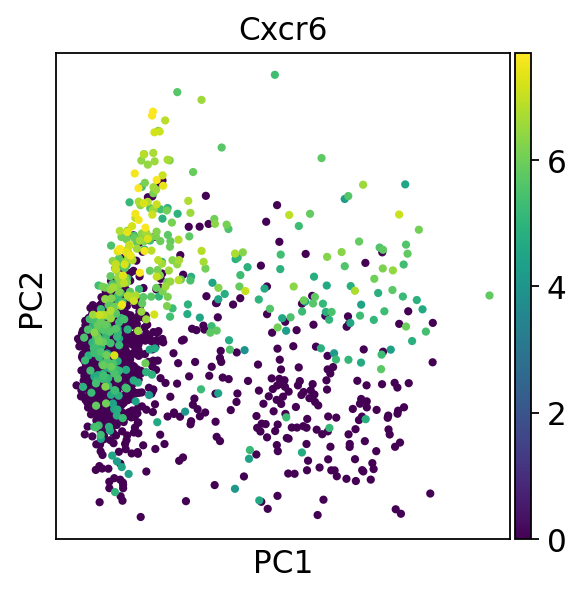

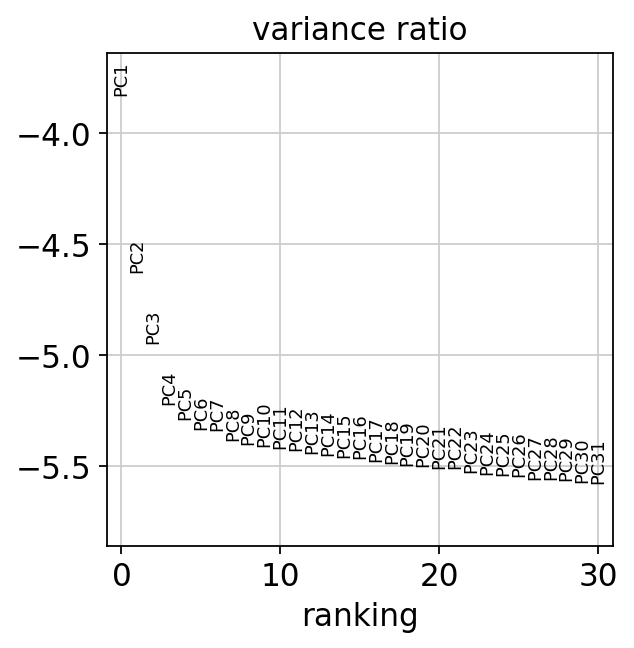

In [13]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='Cxcr6')
sc.pl.pca_variance_ratio(adata, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
computing tSNE
    using 'X_pca' with n_pcs = 20
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:08)


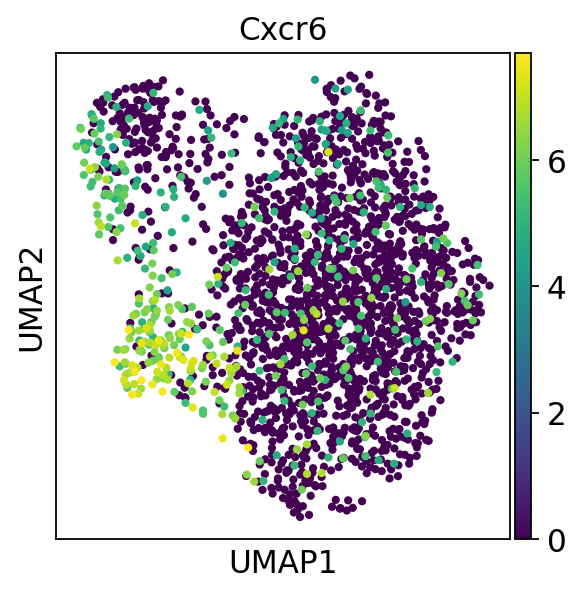

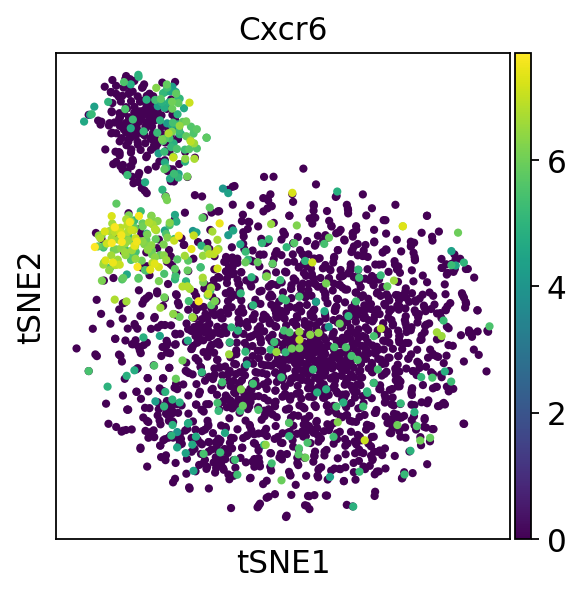

In [14]:
# use only top 10 PCs for neighborhood graph which is then used for UMAP
# nPCs comes from methods Ciucci paper
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.tl.tsne(adata, n_pcs = 20)
sc.pl.umap(adata, color=['Cxcr6'])
sc.pl.tsne(adata, color=['Cxcr6'])

# Cluster number in leidenalg depends on resolution parameter, choosing resolution = 0.75 identifies 8 clusters, which is consistent with the original study

running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.6', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res0.7', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden_res1', the cluster labels (adata.obs, categorical) (0:00:00)


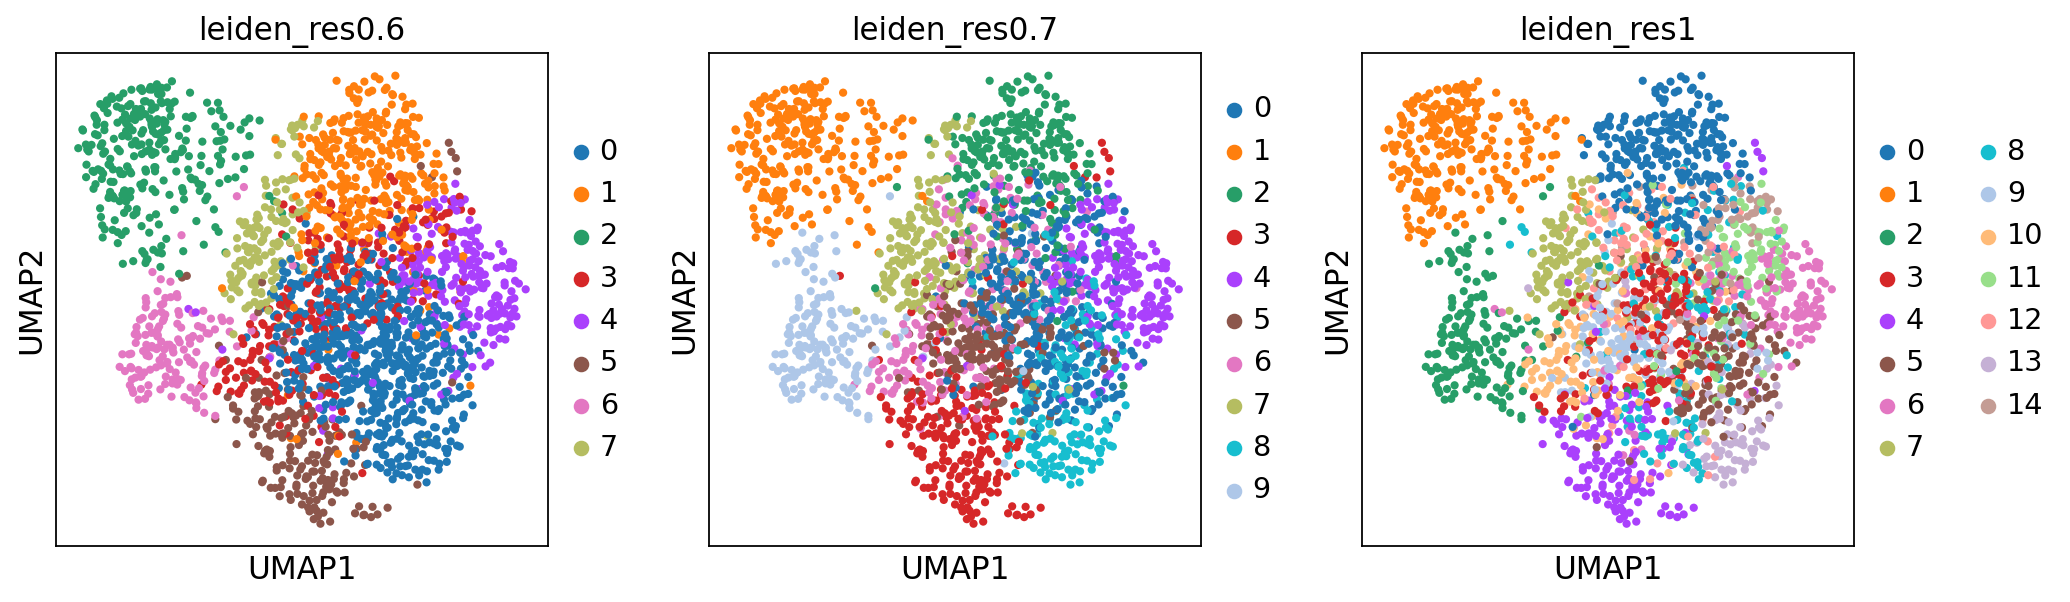

In [15]:
res = [0.6, 0.7, 1]
key = "leiden_res"
keys_2 = [str(x) for x in res]
all_keys = [key+x for x in keys_2]

for val, key in zip(res, all_keys):
    sc.tl.leiden(adata, resolution = val, key_added = key)

sc.pl.umap(adata, color=all_keys)

# cluster matrix from original article fig 1G difficult to reproduce

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_res0.6']`


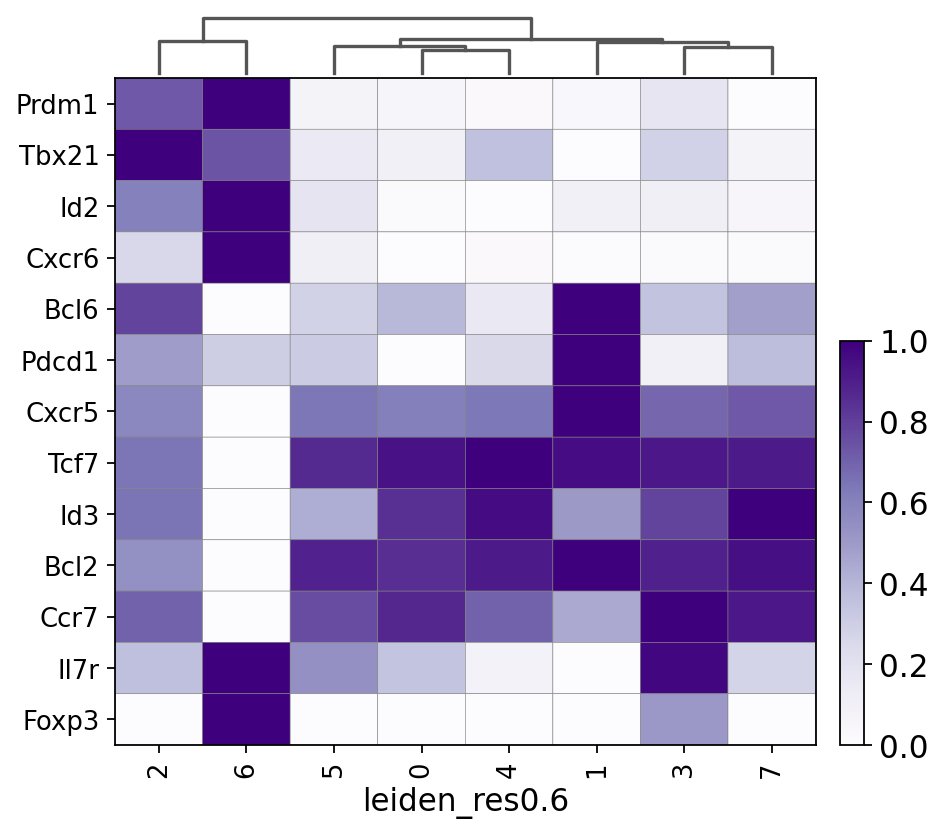

In [16]:
g= sc.pl.matrixplot(adata, ["Prdm1", "Tbx21", "Id2", "Cxcr6", "Bcl6", "Pdcd1", "Cxcr5", "Tcf7", "Id3", "Bcl2", "Ccr7", "Il7r", "Foxp3"], 
                    groupby = "leiden_res0.6", swap_axes = True, figsize = (6,6), dendrogram = True, standard_scale="var", cmap = "Purples")